# gbm3d.m output

In [3]:
import numpy as np
import scipy.io
from skimage import measure, morphology
import matplotlib.pyplot as plt
from matplotlib import cm
import pymesh
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.image import img_to_graph
%matplotlib inline

In [4]:
# Load the output of gbm3d.m after many iterations.
grains = scipy.io.loadmat("../esedoglu/v1_largescale/grains.mat")['grains']
n_grains = len(grains)
print("Loaded %d grains" % n_grains)

Loaded 673 grains


In [5]:
# Notice that indices here goes from 0 to N-1
dims = (128,128,128)

def load_grain(k):
    u = -np.ones(dims)
    ind = grains[k][0]-1
    [x, y, z] = np.unravel_index(ind, dims, order='F')
    val = grains[k][1]
    u[y,x,z] = val
    return u

def build_surface(grain):
    verts, faces = measure.marching_cubes_classic(grain, 0, spacing=(1, 1, 1))
    return verts, faces

def plot_surface(ax, verts, faces):
    ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap=cm.rainbow, lw=1)
def plot_grain(ax, grain):
    verts, faces = build_surface(grain)
    plot_surface(ax, verts, faces)

## Plot structure

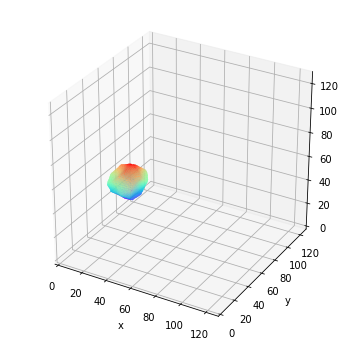

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,127)
ax.set_zlim(0,127)
ax.set_ylim(0,127)
ax.set_xlabel("x")
ax.set_ylabel("y")
# Load grain from MATLAB output
g = load_grain(3)
plot_grain(ax, g)

## Analyze structure

In [9]:
# Build intersecting plane
level = 100
eps = 2
X1 = np.array([127,level,127])
X3 = np.array([0,level+eps,0])
plane = pymesh.generate_box_mesh(X1, X3)

results = [None for i in range(n_grains)]
for i in range(n_grains):
    # Load grain from MATLAB output
    g = load_grain(i)
    # Get vertices and faces (grain triangulation)
    verts, faces = build_surface(g)
    # Build high level mesh
    mesh = pymesh.form_mesh(verts, faces)
    # Intersect
    result = pymesh.boolean(mesh, plane,operation="intersection", engine="carve")
    if len(result.vertices) > 0:
        results[i] = result

In [10]:
# Filter results, some Nones are just non intersecting grains 
results = [r for r in results if r is not None]

Text(0.5,0.92,'Intersection of complete 3D grain structure and a plane')

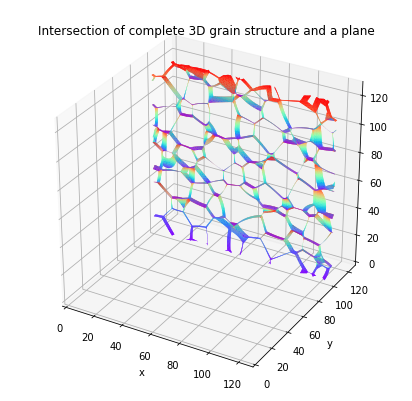

In [11]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0,127)
ax.set_zlim(0,127)
ax.set_ylim(0,127)
ax.set_xlabel("x")
ax.set_ylabel("y")
for r in results:
    plot_surface(ax, r.vertices, r.faces)
ax.set_title("Intersection of complete 3D grain structure and a plane")

In [14]:
# Join all the valid results and postprocess to 2D
finals = []
for r in results:
    mask = r.vertices[:,1] == level
    tmp = r.vertices[mask]
    finals.append(tmp[:, [0,2]])
finals = np.vstack(finals)
# Generate image
finals = (finals * 4).astype(int)
# Binarize output
M = np.zeros((np.max(finals)+1, np.max(finals)+1))
M[finals[:,1], finals[:,0]] = 1
dit = morphology.binary_dilation(M, selem=np.ones((4,4)))
skt = morphology.skeletonize(dit)

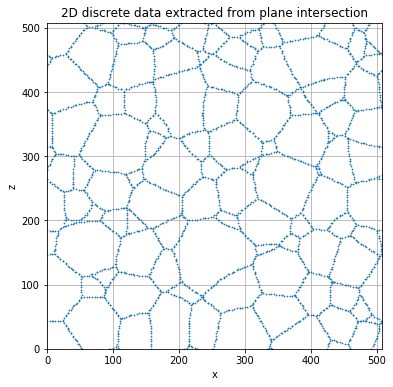

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(finals[:,0], finals[:,1], '.', ms=1)
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_xlim(0,np.max(finals))
ax.set_ylim(0,np.max(finals))
ax.set_title("2D discrete data extracted from plane intersection")
plt.savefig(str(n_grains)+"_example.png")
plt.show()

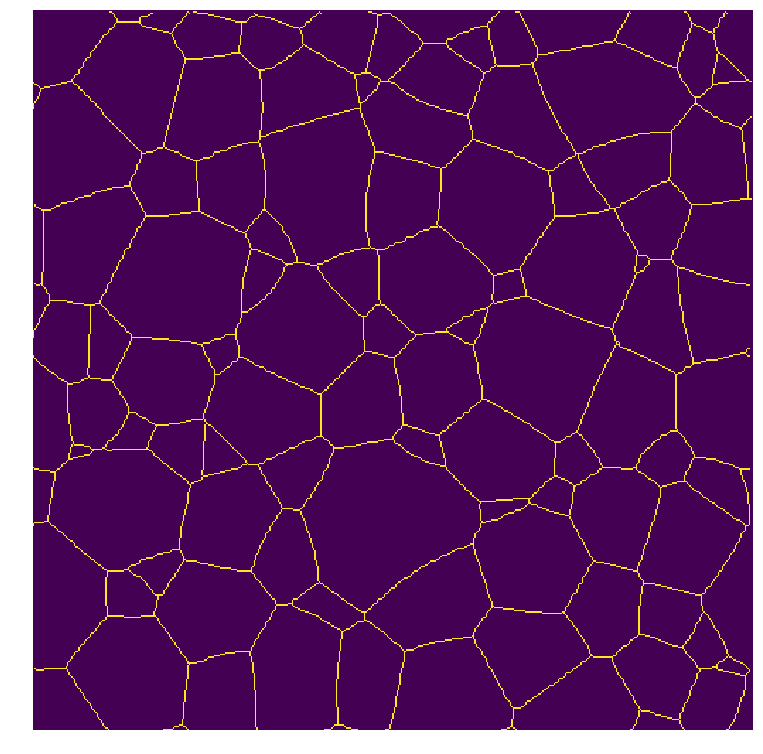

In [17]:
fig = plt.figure(figsize=(10,10))
plt.imshow(skt[::-1])
plt.axis("off")
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.savefig(str(n_grains)+"_example2.png", box_inches='tight', dpi=100,)
plt.show()